# Задание 1 — расчёт корреляций

## Выбор столбцов
Столбцы выбираются по формулам (индексация столбцов 0-based):

$$
i_1 = N \bmod 5
$$

$$
i_2 = (N^2 \bmod 5) + 5
$$

При \(N=4\) индексы считаются так:

$$
i_1 = N \bmod 5 = 4 \bmod 5 = 4
$$

$$
i_2 = (N^2 \bmod 5) + 5 = (4^2 \bmod 5) + 5 = (16 \bmod 5) + 5 = 1 + 5 = 6.
$$


---

## Какие коэффициенты вычисляем и что они означают

### 1. Коэффициент Фехнера (Fechner's sign correlation)  
**Смысл:** учитываем только направление отклонения от среднего (т.е. знак): выше/ниже среднего. Этот коэффициент показывает, в скольких парах переменные меняются в одном направлении относительно своих средних.  

**Формула:**  
$$
\kappa = \frac{1}{n} \sum_{i=1}^n \operatorname{sign}(x_i - \bar{x}) \cdot \operatorname{sign}(y_i - \bar{y}),
$$

где  
$$
\operatorname{sign}(u) = \begin{cases} +1, & u \ge 0,\\ -1, & u < 0. \end{cases}
$$

**Интерпретация:**  
$$
\kappa = 1 \ \text{— полная согласованность знаков},\qquad
\kappa = -1 \ \text{— полная противоположность},\qquad
\kappa \approx 0 \ \text{— нет согласованности по знаку}.
$$

---

### 2. Коэффициент Пирсона (Pearson's \(r\)) — линейная корреляция  
**Смысл:** измеряет силу **линейной** связи между двумя количественными переменными.  

**Формула:**  
$$
r = \frac{\sum_{i=1}^n (x_i-\bar{x})(y_i-\bar{y})}
{\sqrt{\sum_{i=1}^n (x_i-\bar{x})^2}\sqrt{\sum_{i=1}^n (y_i-\bar{y})^2}}.
$$

**Доверительный интервал для коэффициента Пирсона (Fisher z-преобразование):**

1. Преобразуем наблюдаемый коэффициент \(r\) в \(z\)-шкалу:
$$
z = \operatorname{atanh}(r) = \frac{1}{2}\ln\!\left(\frac{1+r}{1-r}\right).
$$

2. Оценка стандартной ошибки в \(z\)-шкале:
$$
SE_z = \frac{1}{\sqrt{n-3}}.
$$

3. 95% доверительный интервал в \(z\)-шкале:
$$
z_{\text{lower,upper}} = z \pm z_{0.975}\cdot SE_z,
$$
где 
$$
z_{0.975}\approx 1.96.
$$ 
Затем границы обратно переводим в шкалу \(r\) через гиперболический тангенс:
$$
r_{\text{lower,upper}} = \tanh(z_{\text{lower,upper}}).
$$

---

### 3. Коэффициент Спирмена (Spearman's \(\rho\)) — ранговая корреляция  
**Смысл:** это Pearson, но по рангам. Измеряет **монотонность** связи (не обязательно линейность).  
**Интерпретация:** 
$$
\rho \in [-1,\,1].
$$
p-value доступен из `scipy.stats.spearmanr`.

---

### 4. Коэффициент Кенделла (Kendall's \(\tau\)) — ранговая мера  
**Смысл:** сравнивает все попарные упорядочения: сколько пар упорядочены одинаково (concordant) и сколько наоборот (discordant).  
**Формула (упрощённо):**  
$$
\tau = \frac{C - D}{\binom{n}{2}},
$$
где \(C\) — число согласованных пар, \(D\) — число несогласованных пар.  
**Интерпретация:** 
$$
\tau \in [-1,\,1].
$$
p-value даёт `scipy.stats.kendalltau`.

---

## Что интерпретируем в выходе
- Значение коэффициента (направление и сила: близко к ±1 — сильная связь; близко к 0 — слабая/нет связи).  
- p-value: если \(p<0.05\) — статистически значимо (обычно), т.е. маловероятно, что нулевая гипотеза (об отсутствии связи) верна.  
- Для Пирсона смотрим также 95% доверительный интервал: если он содержит 0 — линейная связь статистически не подтверждена.


In [5]:
import os
import math
import numpy as np
import pandas as pd
import scipy.stats as stats

# ====== НАСТРОЙКИ ======
N = 4
csv_path = '../../datasets/students_simple.csv'

# ====== проверка файла ======
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Файл {csv_path} не найден по пути: {csv_path}")

# ====== загрузка ======
df = pd.read_csv(csv_path)
cols_all = list(df.columns)
n_cols = len(cols_all)
print("Available columns (index : name):")
for i, name in enumerate(cols_all):
    print(i, ":", name)
print()

# ====== выбор колонок по формулам (0-based index) ======
i1 = N % 5
i2 = (N**2 % 5) + 5

# проверка на выход за границы
if i1 >= n_cols or i2 >= n_cols:
    raise IndexError(f"Выбранные индексы {i1}, {i2} выходят за диапазон колонок (0..{n_cols-1}).")

col_x = cols_all[i1]
col_y = cols_all[i2]
print(f"Selected columns: i1={i1} -> '{col_x}', i2={i2} -> '{col_y}'\n")

# ====== подготовка series (удаляем NaN и приводим к float) ======
x_raw = pd.to_numeric(df[col_x], errors='coerce').dropna().astype(float)
y_raw = pd.to_numeric(df[col_y], errors='coerce').dropna().astype(float)

# Важно: для корреляции нужно совпадение индексов (парные наблюдения).
# Убедимся, что работаем с парами: удаляем строки, где x или y NaN
paired = df[[col_x, col_y]].copy()
paired[col_x] = pd.to_numeric(paired[col_x], errors='coerce')
paired[col_y] = pd.to_numeric(paired[col_y], errors='coerce')
paired = paired.dropna()
x = paired[col_x].astype(float).values
y = paired[col_y].astype(float).values
n = len(x)
print(f"Number of paired observations used: n = {n}\n")

if n == 0:
    raise ValueError("Нет парных числовых наблюдений для выбранных столбцов.")

# ====== 1) Fechner coefficient ======
def fechner_coefficient(a, b):
    # a, b — numpy arrays same length
    ax = a - np.mean(a)
    by = b - np.mean(b)
    sign_ax = np.where(ax >= 0, 1, -1)
    sign_by = np.where(by >= 0, 1, -1)
    kappa = np.mean(sign_ax * sign_by)
    return kappa

fechner_k = fechner_coefficient(x, y)
print("Fechner coefficient (sign correlation):", round(fechner_k, 5))

# ====== 2) Pearson (r) + p-value + 95% CI via Fisher transform ======
pearson_r, pearson_p = stats.pearsonr(x, y)
# Fisher z-transform
def pearson_ci(r, n, alpha=0.05):
    # return (r_lower, r_upper)
    if n <= 3:
        return (np.nan, np.nan)
    z = np.arctanh(r)  # atanh
    se = 1.0 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)
    z_lo, z_hi = z - z_crit*se, z + z_crit*se
    r_lo, r_hi = np.tanh([z_lo, z_hi])
    return float(r_lo), float(r_hi)

r_lo, r_hi = pearson_ci(pearson_r, n, alpha=0.05)
print(f"Pearson r = {pearson_r:.5f}, p-value = {pearson_p:.5e}")
print(f"95% CI for r (Fisher): ({r_lo:.5f}, {r_hi:.5f})")

# ====== 3) Spearman rho ======
spearman_rho, spearman_p = stats.spearmanr(x, y)
print(f"Spearman rho = {spearman_rho:.5f}, p-value = {spearman_p:.5e}")

# ====== 4) Kendall tau ======
kendall_tau, kendall_p = stats.kendalltau(x, y)
print(f"Kendall tau = {kendall_tau:.5f}, p-value = {kendall_p:.5e}")

# ====== (опционально) собрать результаты в DataFrame для аккуратного вывода ======
res = pd.DataFrame({
    "measure": ["Fechner", "Pearson", "Spearman", "Kendall"],
    "value": [fechner_k, pearson_r, spearman_rho, kendall_tau],
    "p_value": [np.nan, pearson_p, spearman_p, kendall_p]
})
res.loc[1, "ci_95"] = f"({r_lo:.5f},{r_hi:.5f})"
print("\nSummary:")
display(res)


Available columns (index : name):
0 : height
1 : mass
2 : income
3 : iq
4 : pages
5 : age
6 : bmi
7 : work_exp
8 : friends
9 : test_time

Selected columns: i1=4 -> 'pages', i2=6 -> 'bmi'

Number of paired observations used: n = 20

Fechner coefficient (sign correlation): -0.4
Pearson r = -0.17950, p-value = 4.48911e-01
95% CI for r (Fisher): (-0.57625, 0.28572)
Spearman rho = -0.32394, p-value = 1.63519e-01
Kendall tau = -0.24424, p-value = 1.53836e-01

Summary:


,measure,value,p_value,ci_95
0,Fechner,-0.400000,NaN,NaN
1,Pearson,-0.179497,0.448911,"(-0.57625,0.28572)"
2,Spearman,-0.323940,0.163519,NaN
3,Kendall,-0.244239,0.153836,NaN


## 📊 Интерпретация результатов корреляционного анализа

Пусть выбраны признаки:
- **x = pages** — количество страниц, прочитанных студентом;
- **y = bmi** — индекс массы тела студента.

Количество наблюдений:  
$$
n = 20
$$

---

### 1. Коэффициент Фехнера

Знакокорреляция (Fechner) показывает **долю совпадений знаков отклонений** от средних значений.  
Для выборки:

$$
r_F = -0.4
$$

**Интерпретация:**
- Значение 
$$
r_F = -0.4
$$ 
указывает на **умеренную обратную (отрицательную) зависимость**:  
  когда значение одного признака растёт, другой, как правило, уменьшается.
- При 
$$
r_F = 0
$$ 
зависимость отсутствует, при 
$$
r_F = \pm 1
$$ 
— полная согласованность/несогласованность знаков.

---

### 2. Коэффициент Пирсона

Классическая линейная корреляция:

$$
r_P = -0.1795
$$

95% доверительный интервал:
$$
r_P \in (-0.576,\; 0.286)
$$

**Интерпретация:**
- Наблюдается **слабая отрицательная линейная зависимость**.  
- Значение 
$$
r_P
$$
близко к нулю, а доверительный интервал охватывает 0,  
  поэтому статистически значимой связи **не выявлено** (p-value ≈ 0.45).

---

### 3. Коэффициент Спирмена

Ранговая корреляция Спирмена:
$$
\rho = -0.324
$$

**Интерпретация:**
- Значение 
$$
rho < 0
$$ говорит о **тенденции к обратной монотонной зависимости**.  
- Однако по величине 
$$
|\rho| < 0.4
$$
а p-value ≈ 0.16 → связь **слабая и статистически незначимая**.  
- Это означает, что при увеличении количества прочитанных страниц BMI в среднем немного снижается,  
  но закономерность неустойчивая.

---

### 4. Коэффициент Кенделла

Ранговая мера согласованности пар:
$$
\tau = -0.244
$$

**Интерпретация:**
- Значение 
$$
\tau
$$ также показывает **слабую обратную связь**.  
- p-value ≈ 0.15 → статистически значимой зависимости **не наблюдается**.  
- Приблизительно 62% пар согласованы, а 38% — несогласованы (или наоборот).

---

## 🧩 Сравнение коэффициентов

| Мера | Значение | Характер зависимости | Статистическая значимость |
|:------|:----------|:--------------------|:--------------------------|
| Фехнера | -0.40 | умеренная отрицательная | — |
| Пирсона | -0.18 | слабая отрицательная (линейная) | незначима |
| Спирмена | -0.32 | слабая отрицательная (монотонная) | незначима |
| Кенделла | -0.24 | слабая отрицательная (парная) | незначима |

---

## 🧠 Общий вывод

Все четыре коэффициента (включая Фехнера, Пирсона, Спирмена и Кенделла) показали **слабую отрицательную зависимость** между количеством прочитанных страниц и индексом массы тела (BMI).  
Это может означать, что студенты, которые читают больше страниц, **немного стройнее**, но эта тенденция **не является статистически подтверждённой** при уровне значимости 0.05.

**Вывод:**  
Между признаками *pages* и *bmi* наблюдается слабая, статистически незначимая отрицательная корреляция.  
Следовательно, можно считать, что **линейной или монотонной зависимости между ними не обнаружено.**


## 📊 2. Визуализация данных

### 🎯 Цель
Цель визуализации — исследовать распределения данных и характер взаимосвязи между признаками.

---

### 📘 1. Гистограммы
**Гистограмма** показывает частоты значений признака, сгруппированные по интервалам (корзинам).  
Позволяет определить:
- форму распределения (нормальное, скошенное и т.д.);
- наличие выбросов;
- особенности вариации данных.

---

### 📗 2. Диаграмма рассеяния (Scatter Plot)
**Диаграмма рассеяния** показывает зависимость между двумя переменными:  
каждая точка — это одна пара наблюдений $(x_i, y_i)$.

**Интерпретация:**
- Восходящее облако точек → положительная зависимость.  
- Нисходящее → отрицательная.  
- Хаотичное → зависимости нет.  

---

### ⚙️ Исходные данные
Из первого задания:
- $x =$ **pages** — количество прочитанных страниц;
- $y =$ **bmi** — индекс массы тела.  
Количество наблюдений:  
$$n = 20$$


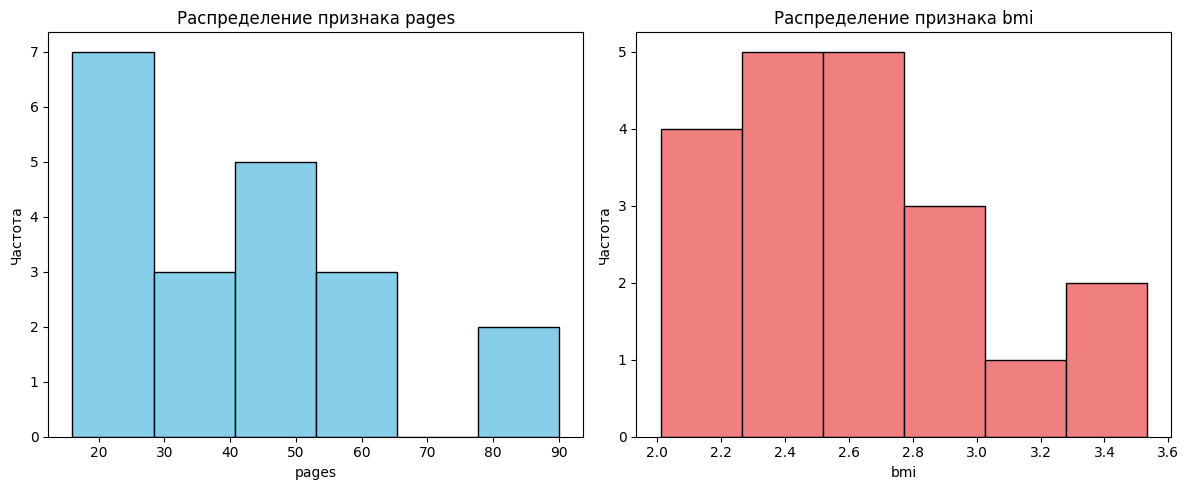

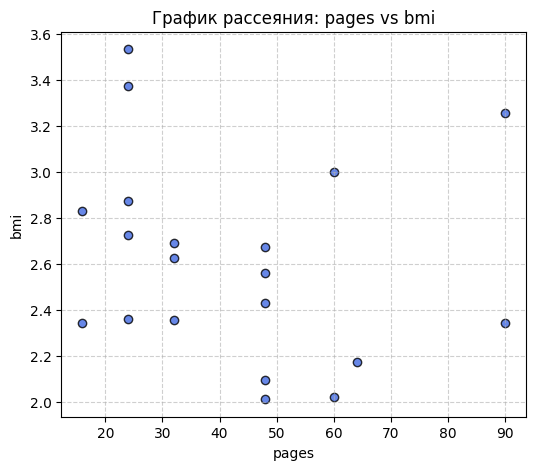

In [7]:
# === 2. Визуализация (только matplotlib) ===

import matplotlib.pyplot as plt
import numpy as np

# --- Гистограммы ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(x, bins='sturges', edgecolor='black', color='skyblue')
plt.title('Распределение признака pages')
plt.xlabel('pages')
plt.ylabel('Частота')

plt.subplot(1,2,2)
plt.hist(y, bins='sturges', edgecolor='black', color='lightcoral')
plt.title('Распределение признака bmi')
plt.xlabel('bmi')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

# --- График рассеяния ---
plt.figure(figsize=(6,5))
plt.scatter(x, y, color='royalblue', edgecolor='black', alpha=0.8)
plt.title('График рассеяния: pages vs bmi')
plt.xlabel('pages')
plt.ylabel('bmi')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## 📊 Анализ визуализации

### 1. Гистограммы распределений

На рисунке представлены гистограммы признаков **`pages`** (слева) и **`bmi`** (справа).

- **Гистограмма `pages`**  
  Отражает распределение количества страниц.  
  Наблюдается **неравномерное распределение**: большинство значений сосредоточено в диапазоне **15–50**, в то время как отдельные значения около **80–90** выступают как **выбросы**.  
  Распределение имеет **положительную асимметрию (смещено вправо)**, что может свидетельствовать о наличии редких, но больших значений признака.

- **Гистограмма `bmi`**  
  Распределение признака `bmi` выглядит **относительно симметричным** и ближе к нормальному.  
  Большинство наблюдений находятся в диапазоне **2.4–2.8**, ярко выраженных выбросов не видно.  
  Небольшое смещение влево может указывать на **слабую отрицательную асимметрию**.

---

### 2. График рассеяния (Scatter Plot)

На графике рассеяния представлена зависимость **`bmi` от `pages`**.

- Точки расположены **случайным образом**, без видимой линейной или криволинейной зависимости.  
- Это указывает на **слабую или отсутствующую корреляцию** между переменными.  
- Увеличение количества страниц (`pages`) **не сопровождается систематическим изменением** `bmi`.

---

## 📈 Вывод

- Распределения признаков имеют различную форму:  
  - `pages` — **асимметричное распределение с выбросами**,  
  - `bmi` — **более симметричное и сгруппированное** вокруг среднего значения.  
- Между `pages` и `bmi` **нет выраженной зависимости**, что подтверждает визуальная оценка по scatter plot.  
- Таким образом, можно сделать вывод, что **признаки слабо связаны между собой** и отражают **разные стороны данных**.


Используем столбцы: x = "iq", y = "age"

Результаты подгонки:
linear      : R^2=0.427084, SSE=143.687381
quadratic   : R^2=0.468243, SSE=133.364749
hyperbolic  : R^2=0.447755, SSE=138.502922
exponential : R^2=0.408437, SSE=148.364023


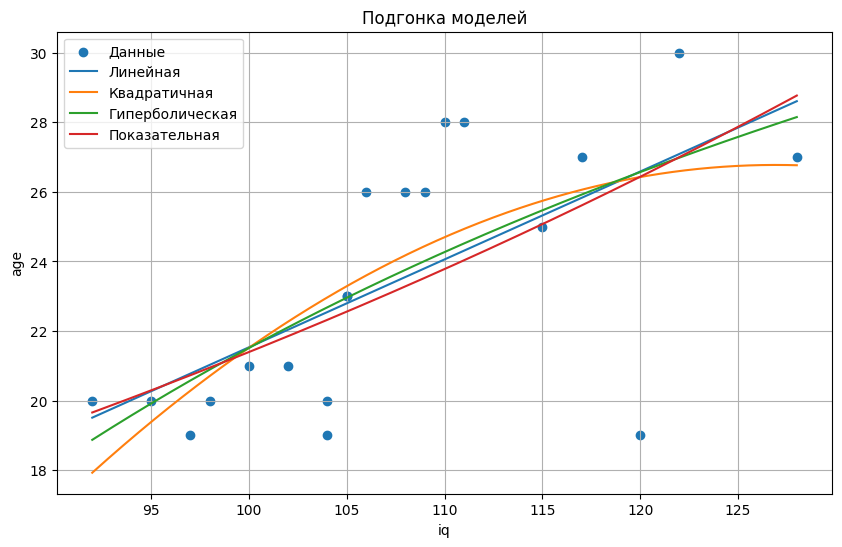

Лучшая модель: quadratic, Худшая модель: exponential

QUADRATIC — F=7.484734, p-value=0.00466192, df1=2, df2=17

EXPONENTIAL — F=12.942271, p-value=0.00205845, df1=1, df2=18


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import lstsq
from scipy import stats

# Параметры
csv_path = '../../datasets/students_simple.csv'  # путь к датасету
N = 4

# Загрузка данных
df = pd.read_csv(csv_path)

# Выбор столбцов
col1_idx = N % 5
col2_idx = (N**2 % 5) + 5

# Попытка взять столбцы по индексам (1-based -> 0-based)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
try:
    col1_name = df.columns[col1_idx]
    col2_name = df.columns[col2_idx]
    # если выбранные столбцы не числовые — fall back
    if col1_name not in numeric_cols or col2_name not in numeric_cols:
        raise ValueError('Chosen cols are not numeric')
except Exception:
    # fallback: первые два числовых столбца
    if len(numeric_cols) < 2:
        raise ValueError('В датасете меньше двух числовых столбцов')
    col1_name, col2_name = numeric_cols[0], numeric_cols[1]

print(f'Используем столбцы: x = "{col1_name}", y = "{col2_name}"')

x = df[col1_name].to_numpy().astype(float)
y = df[col2_name].to_numpy().astype(float)

# Очистка пар с NaN
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]

n = len(x)
if n < 3:
    raise ValueError('Недостаточно наблюдений после очистки')

# Вспомогательные функции
def fit_linear(x, y):
    X = np.vstack([x, np.ones_like(x)]).T
    w, *_ = lstsq(X, y, rcond=None)
    y_pred = X @ w
    return w, y_pred, X

def fit_quadratic(x, y):
    X = np.vstack([x**2, x, np.ones_like(x)]).T
    w, *_ = lstsq(X, y, rcond=None)
    y_pred = X @ w
    return w, y_pred, X

def fit_hyperbolic(x, y, eps=1e-9):
    z = 1.0 / (x + eps)
    X = np.vstack([z, np.ones_like(z)]).T
    w, *_ = lstsq(X, y, rcond=None)
    y_pred = X @ w
    return w, y_pred, X

def fit_exponential(x, y):
    # модель y = w1^x * w0 -> ln y = x ln w1 + ln w0
    mask_pos = y > 0
    if mask_pos.sum() < max(3, 0.5*len(y)):
        # если мало положительных значений — попробуем сдвинуть
        shift = abs(np.min(y)) + 1e-6
        y_adj = y + shift
        note = f'y содержал неположительные значения: применён сдвиг {shift:.6g}'
    else:
        y_adj = y.copy()
        note = None
    ln_y = np.log(y_adj[mask_pos])
    x_pos = x[mask_pos]
    X = np.vstack([x_pos, np.ones_like(x_pos)]).T
    ab, *_ = lstsq(X, ln_y, rcond=None)
    b, a = ab[0], ab[1]
    w1 = np.exp(b)
    w0 = np.exp(a)
    # применяем модель ко всем x (если использовался shift, то надо скорректировать предсказания)
    y_pred = w0 * (w1**x)
    if note:
        return (w0, w1), y_pred, X, note
    return (w0, w1), y_pred, X, None

# Подгоняем модели
models = {}

w_lin, y_lin, X_lin = fit_linear(x, y)
models['linear'] = {'coef': w_lin, 'y_pred': y_lin, 'X': X_lin, 'p': 1}

w_quad, y_quad, X_quad = fit_quadratic(x, y)
models['quadratic'] = {'coef': w_quad, 'y_pred': y_quad, 'X': X_quad, 'p': 2}

w_hyp, y_hyp, X_hyp = fit_hyperbolic(x, y)
models['hyperbolic'] = {'coef': w_hyp, 'y_pred': y_hyp, 'X': X_hyp, 'p': 1}

w_exp, y_exp, X_exp, exp_note = fit_exponential(x, y)
models['exponential'] = {'coef': w_exp, 'y_pred': y_exp, 'X': X_exp, 'p': 1}
if exp_note:
    print(exp_note)

# Функции качества
def ss_tot(y):
    return np.sum((y - np.mean(y))**2)

def ss_res(y, y_pred):
    return np.sum((y - y_pred)**2)

results = {}
SST = ss_tot(y)

for name, info in models.items():
    y_pred = info['y_pred']
    sse = ss_res(y, y_pred)
    ssr = SST - sse
    r2 = 1 - sse / SST
    results[name] = {'sse': sse, 'ssr': ssr, 'r2': r2}

# Выводим сводку
print('\nРезультаты подгонки:')
for name, res in results.items():
    print(f"{name:12s}: R^2={res['r2']:.6f}, SSE={res['sse']:.6f}")

# Графики
xs = np.linspace(np.min(x), np.max(x), 500)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Данные')

# линия для линейной
w = models['linear']['coef']
plt.plot(xs, w[0]*xs + w[1], label='Линейная')

# квадратичная
w = models['quadratic']['coef']
plt.plot(xs, w[0]*xs**2 + w[1]*xs + w[2], label='Квадратичная')

# гиперболическая
w = models['hyperbolic']['coef']
plt.plot(xs, w[0]/(xs) + w[1], label='Гиперболическая')

# показательная
w0, w1 = models['exponential']['coef']
plt.plot(xs, w0*(w1**xs), label='Показательная')

plt.legend()
plt.xlabel(col1_name)
plt.ylabel(col2_name)
plt.title('Подгонка моделей')
plt.grid(True)
plt.show()

# Выбор лучшей и худшей модели по R^2
sorted_models = sorted(results.items(), key=lambda kv: kv[1]['r2'])
worst_name, best_name = sorted_models[0][0], sorted_models[-1][0]
print(f'Лучшая модель: {best_name}, Худшая модель: {worst_name}')

# Критерий Фишера для двух моделей: считаем F для каждой модели (общая форма)

def fisher_test(y, y_pred, p):
    n = len(y)
    sse = np.sum((y - y_pred)**2)
    ssr = np.sum((y_pred - np.mean(y))**2)
    df1 = p
    df2 = n - p - 1
    msr = ssr / df1 if df1>0 else np.nan
    mse = sse / df2 if df2>0 else np.nan
    F = msr / mse if (df1>0 and df2>0) else np.nan
    p_value = stats.f.sf(F, df1, df2) if (df1>0 and df2>0) else np.nan
    return {'F': F, 'p_value': p_value, 'df1': df1, 'df2': df2}

for name in [best_name, worst_name]:
    inf = models[name]
    ft = fisher_test(y, inf['y_pred'], inf['p'])
    print(f"\n{name.upper()} — F={ft['F']:.6f}, p-value={ft['p_value']:.6g}, df1={ft['df1']}, df2={ft['df2']}")

